# AWS Architecture Application - New York Taxi Company
# (Linear Regression + Knn)

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pyproj import Geod
import scipy

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.4f' % x)

TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'

In [44]:
test = pd.read_csv(TEST_PATH)
print('Null values:',test.isnull().sum().sum())

Null values: 0


In [3]:
df_temp = pd.read_csv(TRAIN_PATH, nrows=100000)

In [4]:
def clean_df(df):
    df['pickup_datetime'] = df['pickup_datetime'].str.slice(0, 15)
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    
    #reverse incorrectly assigned longitude/latitude values
    df = df.assign(rev=df.dropoff_latitude<df.dropoff_longitude)
    idx = (df['rev'] == 1)
    df.loc[idx,['dropoff_longitude','dropoff_latitude']] = df.loc[idx,['dropoff_latitude','dropoff_longitude']].values
    df.loc[idx,['pickup_longitude','pickup_latitude']] = df.loc[idx,['pickup_latitude','pickup_longitude']].values
    
    #remove data points outside appropriate ranges
    criteria = (
    " 0 < fare_amount <= 500"
    " and 0 < passenger_count <= 6 "
    " and -75 <= pickup_longitude <= -72 "
    " and -75 <= dropoff_longitude <= -72 "
    " and 40 <= pickup_latitude <= 42 "
    " and 40 <= dropoff_latitude <= 42 "
    )
    df = (df
          .dropna()
          .query(criteria)
          .reset_index()
          .drop(columns=['rev', 'index'])          
         )
    return df

def load_df(nrows=None, features=None):
    #load dataframe in chunks if the number of rows requested is high (currently only using 1 million rows for faster training)
    cols = [
        'fare_amount', 'pickup_datetime','pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude', 'passenger_count'
    ]
    df_as_list = []
    for df_chunk in pd.read_csv(TRAIN_PATH, usecols=cols, nrows=nrows, chunksize=5000000):
        df_chunk = clean_df(df_chunk) 
        if features == 'explore':
            df_chunk = exploration_features(df_chunk)
        elif features == 'model':
            df_chunk = modelling_features(df_chunk)
        else:
            df_chunk = df_chunk.drop(columns='pickup_datetime')
        df_as_list.append(df_chunk)
    df = pd.concat(df_as_list)
    return df

In [45]:
train = load_df(10000000)

In [6]:
def get_split_sets(train):
    x = train.drop(columns=['fare_amount'])
    y = train['fare_amount'].values
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=0)
    return x_train, x_val, y_train, y_val


def lin_model(x_train, x_val, y_train, y_val):
    model = LinearRegression()
    model.fit(x_train, y_train)
    pred = model.predict(x_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    return model, rmse, pred


def knn_model(x_train, x_val, y_train, y_val, neighbors):
    min_rmse = 1000
    for n in neighbors:
        knn = KNeighborsRegressor(n_neighbors=n)
        knn.fit(x_train, y_train)
        pred = knn.predict(x_val)
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        if rmse < min_rmse:
            min_rmse = rmse
            model = knn
            best_pred = pred
        print('Neighbours', n, 'RMSE', rmse)
    return model, min_rmse, best_pred

In [7]:
train = load_df(1000000)
x_train, x_val, y_train, y_val= get_split_sets(train)
test = pd.read_csv(TEST_PATH)
x_test = test.drop(columns=['key'])

In [8]:
lin_init_model, lin_init_rmse, lin_init_pred = lin_model(x_train, x_val, y_train, y_val)

In [9]:
k_choices = [10,20,30,40,50,60]
knn_cols = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']
knn_init, knn_init_rmse, knn_init_pred = knn_model(x_train[knn_cols], x_val[knn_cols], y_train, y_val, k_choices)

Neighbours 10 RMSE 4.073663630159872
Neighbours 20 RMSE 4.041465568157725
Neighbours 30 RMSE 4.020998873844712
Neighbours 40 RMSE 4.035142136358406
Neighbours 50 RMSE 4.0545412983301805
Neighbours 60 RMSE 4.064264822366651


In [14]:
def distance(lon1,lat1,lon2,lat2):
    az12,az21,dist = Geod(ellps='WGS84').inv(lon1,lat1,lon2,lat2)
    return dist
def direction(lon1,lat1,lon2,lat2):
    az12,az21,dist = Geod(ellps='WGS84').inv(lon1,lat1,lon2,lat2)
    return az12

def shared_features(df):

    rows = len(df)
    #these long/lat values are needed as lists to hand to the distance function
    nyc_long, nyc_lat = [-74.001541]*rows, [40.724944]*rows    
    jfk_long, jfk_lat = [-73.785937]*rows, [40.645494]*rows
    lga_long, lga_lat = [-73.872067]*rows, [40.774071]*rows
    nla_long, nla_lat = [-74.177721]*rows, [40.690764]*rows
    chp_long, chp_lat = [-73.137393]*rows, [41.366138]*rows
    exp_long, exp_lat = [-74.0375]*rows, [40.736]*rows
    pickup_long = df.pickup_longitude.tolist()
    pickup_lat = df.pickup_latitude.tolist()
    dropoff_long = df.dropoff_longitude.tolist()
    dropoff_lat = df.dropoff_latitude.tolist()
    
    #add features to the data
    df = df.assign(
        #time features
        year=df.pickup_datetime.dt.year,
        dayofyear=df.pickup_datetime.dt.dayofyear,
        weekday=df.pickup_datetime.dt.dayofweek,
        time=(df.pickup_datetime.dt.hour+df.pickup_datetime.dt.minute/5),
        
        #distance between pickup and dropoff, and bearing from pickup to dropoff
        distance=distance(pickup_long, pickup_lat, dropoff_long, dropoff_lat),
        direction=direction(pickup_long, pickup_lat, dropoff_long, dropoff_lat),
        
        #distance from locations
        pickup_dist_nyc=pd.Series(distance(pickup_long, pickup_lat, nyc_long, nyc_lat)),
        dropoff_dist_nyc=pd.Series(distance(dropoff_long, dropoff_lat, nyc_long, nyc_lat)),
        pickup_dist_jfk=pd.Series(distance(pickup_long, pickup_lat, jfk_long, jfk_lat)),
        dropoff_dist_jfk=pd.Series(distance(dropoff_long, dropoff_lat, jfk_long, jfk_lat)),
        pickup_dist_lga=pd.Series(distance(pickup_long, pickup_lat, lga_long, lga_lat)),
        dropoff_dist_lga=pd.Series(distance(dropoff_long, dropoff_lat, lga_long, lga_lat)),
        pickup_dist_nla=pd.Series(distance(pickup_long, pickup_lat, nla_long, nla_lat)),
        dropoff_dist_nla=pd.Series(distance(dropoff_long, dropoff_lat, nla_long, nla_lat)),
        pickup_dist_chp=pd.Series(distance(pickup_long, pickup_lat, chp_long, chp_lat)),
        dropoff_dist_chp=pd.Series(distance(dropoff_long, dropoff_lat, chp_long, chp_lat)),
        pickup_dist_exp=pd.Series(distance(pickup_long, pickup_lat, exp_long, exp_lat)),
        dropoff_dist_exp=pd.Series(distance(dropoff_long, dropoff_lat, exp_long, exp_lat))
    )
    return df


def exploration_features(df):

    df = shared_features(df)
    df = (
        df
        .assign(
            hour=df.pickup_datetime.dt.hour,
            close_to_airport='No',
            fare_per_km=df.fare_amount*1000/df.distance,
            direction_bucket = pd.cut(df.direction, np.linspace(-180, 180, 37)),

            #small location buckets
            pickup_long_bucket=pd.cut(df.pickup_longitude, bins=2550, labels=False),
            pickup_lat_bucket=pd.cut(df.pickup_latitude, bins=2200, labels=False),
            dropoff_long_bucket=pd.cut(df.dropoff_longitude, bins=2550, labels=False),
            dropoff_lat_bucket=pd.cut(df.dropoff_latitude, bins=2200, labels=False),

            #large location buckets
            pickup_long_bucket_big=pd.cut(df.pickup_longitude, bins=255, labels=False),
            pickup_lat_bucket_big=pd.cut(df.pickup_latitude, bins=220, labels=False),
            dropoff_long_bucket_big=pd.cut(df.dropoff_longitude, bins=255, labels=False),
            dropoff_lat_bucket_big=pd.cut(df.dropoff_latitude, bins=220, labels=False)
        )
        .drop(columns='pickup_datetime')
        .query("0 < distance")
    )
    df.loc[((df['pickup_dist_jfk']<1500) | (df['dropoff_dist_jfk']<1500)), 'close_to_airport'] = 'JFK'
    df.loc[((df['pickup_dist_lga']<1500) | (df['dropoff_dist_lga']<1500)), 'close_to_airport'] = 'LaGuardia'
    df.loc[((df['pickup_dist_nla']<1500) | (df['dropoff_dist_nla']<1500)), 'close_to_airport'] = 'Newark'  
    return df

In [15]:
train = load_df(5000000, features='explore')

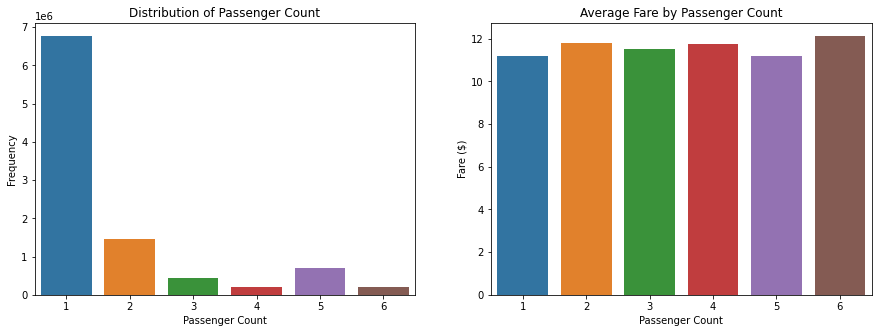

In [46]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.countplot(train.passenger_count, ax=ax[0])
ax[0].set_xlabel('Passenger Count')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Distribution of Passenger Count')
sns.barplot(train.passenger_count, train.fare_amount, ax=ax[1], ci=None)
ax[1].set_xlabel('Passenger Count')
ax[1].set_ylabel('Fare ($)')
ax[1].set_title('Average Fare by Passenger Count')
fig.show()

Text(0, 0.5, 'Fare ($)')

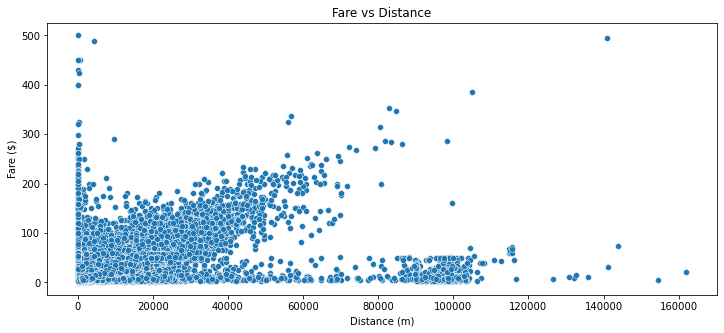

In [17]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(x='distance', y='fare_amount', data=train).set_title('Fare vs Distance')
plt.xlabel('Distance (m)')
plt.ylabel('Fare ($)')

Text(0, 0.5, 'Long Trip Fare ($)')

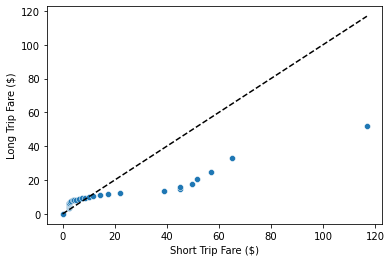

In [18]:
percs = np.linspace(0,99,34)
short = np.percentile(train[train['distance']<=50].fare_amount, percs)
long = np.percentile(train[train['distance']>50].fare_amount, percs)
sns.scatterplot(x=short, y=long)
x = np.linspace(np.min((short.min(),long.min())), np.max((short.max(),long.max())))
plt.plot(x,x, color="k", ls="--")
plt.title('')
plt.xlabel('Short Trip Fare ($)')
plt.ylabel('Long Trip Fare ($)')

In [19]:
ks = scipy.stats.ks_2samp(
    train.where(train.distance > 50).dropna()['fare_amount'],
    train.where(train.distance <= 50).dropna()['fare_amount']
)
print('p-value:', ks[1])

p-value: 0.0


In [20]:
long_trips = train[train.distance>75000].fare_amount.count()
print(long_trips, 'trips over 75km.')

788 trips over 75km.


Average fare for distance over 75km: 21.086713197969516
Average fare for distance 50-75km: 113.41310975609754


Text(0.5, 0, 'Distance')

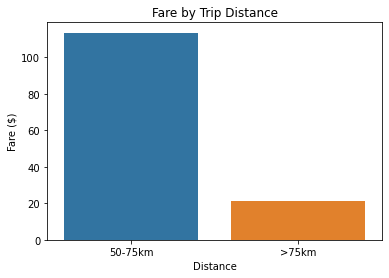

In [21]:
print('Average fare for distance over 75km:', train[train.distance>75000].fare_amount.mean())
print('Average fare for distance 50-75km:', train.query('50000 < distance < 75000').fare_amount.mean())
sns.barplot(['50-75km', '>75km'],[train.query('50000 < distance < 75000').fare_amount.mean(),train[train.distance>75000].fare_amount.mean()])
plt.title('Fare by Trip Distance')
plt.ylabel('Fare ($)')
plt.xlabel('Distance')

Average fare for distance over 75km: 21.086713197969516
Average fare for distance 50-75km: 113.41310975609754


Text(0.5, 0, 'Distance')

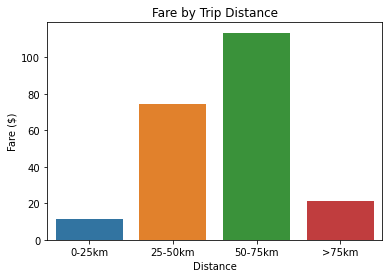

In [22]:
print('Average fare for distance over 75km:', train[train.distance>75000].fare_amount.mean())
print('Average fare for distance 50-75km:', train.query('50000 < distance < 75000').fare_amount.mean())
sns.barplot(['0-25km','25-50km','50-75km', '>75km'],[train.query('0 < distance < 25000').fare_amount.mean(),train.query('25000 < distance < 50000').fare_amount.mean(),train.query('50000 < distance < 75000').fare_amount.mean(),train[train.distance>75000].fare_amount.mean()])
plt.title('Fare by Trip Distance')
plt.ylabel('Fare ($)')
plt.xlabel('Distance')

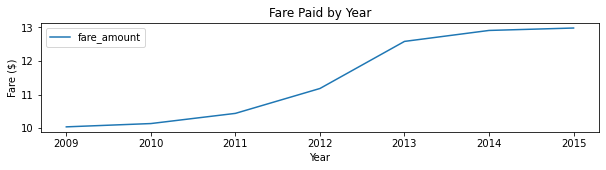

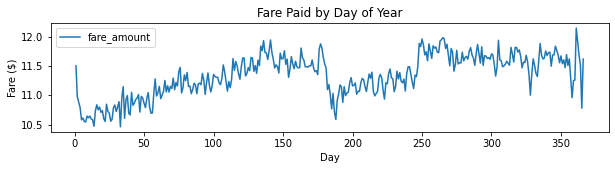

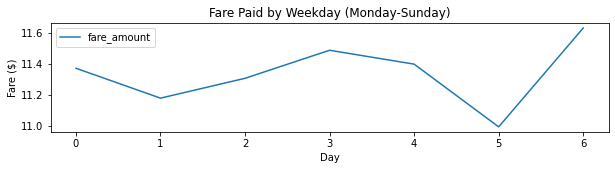

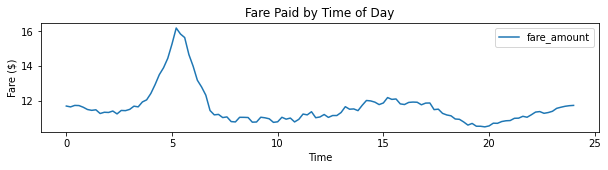

In [25]:
train.pivot_table('fare_amount', index='year').plot(figsize=(10,2))
plt.title('Fare Paid by Year')
plt.ylabel('Fare ($)')
plt.xlabel('Year')
train.pivot_table('fare_amount', index='dayofyear').plot(figsize=(10,2))
plt.title('Fare Paid by Day of Year')
plt.ylabel('Fare ($)')
plt.xlabel('Day')
train.pivot_table('fare_amount', index='weekday').plot(figsize=(10,2))
plt.title('Fare Paid by Weekday (Monday-Sunday)')
plt.ylabel('Fare ($)')
plt.xlabel('Day')
train.pivot_table('fare_amount', index='time').plot(figsize=(10,2))
plt.ylabel('Fare ($)')
plt.xlabel('Time')
plt.title('Fare Paid by Time of Day')
plt.show()

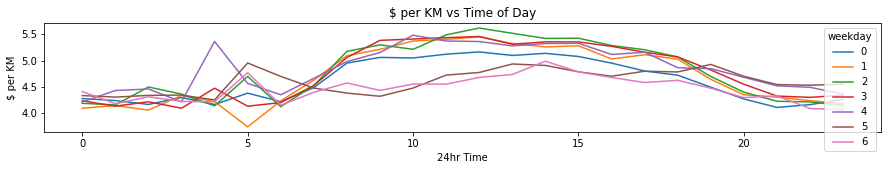

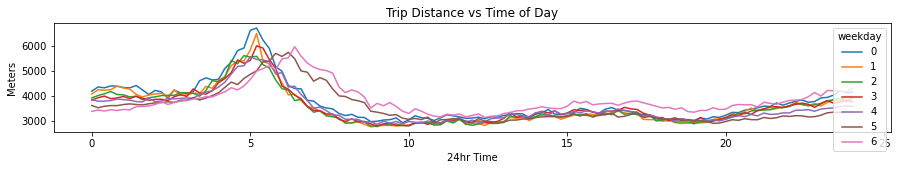

In [26]:
train.query('50 < distance').pivot_table('fare_per_km', index='hour', columns='weekday').plot(figsize=(15,2))
plt.title('$ per KM vs Time of Day')
plt.ylabel('$ per KM')
plt.xlabel('24hr Time')
train.pivot_table('distance', index='time', columns='weekday').plot(figsize=(15,2))
plt.ylabel('Meters')
plt.xlabel('24hr Time')
plt.title('Trip Distance vs Time of Day')
plt.show()

Text(0.5, 1.0, 'Distance from City Centre vs Time of Day')

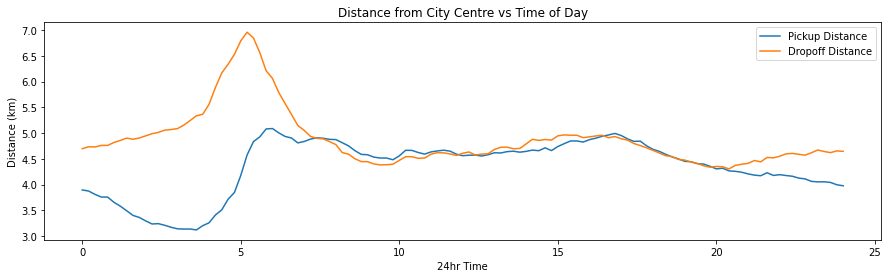

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
plt.plot(train.groupby('time').time.unique(), train.groupby('time')['pickup_dist_nyc'].mean()/1000, label='Pickup Distance')
plt.plot(train.groupby('time').time.unique(), train.groupby('time')['dropoff_dist_nyc'].mean()/1000, label='Dropoff Distance')
plt.legend(loc="upper right")
plt.xlabel('24hr Time')
plt.ylabel('Distance (km)')
plt.legend()
plt.title('Distance from City Centre vs Time of Day')

Text(0, 0.5, 'Fare ($)')

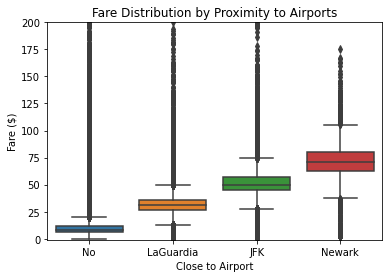

In [29]:
sns.boxplot(x=train['close_to_airport'], y=train['fare_amount'])
plt.title('Fare Distribution by Proximity to Airports')
plt.ylim(-1,200)
plt.xlabel('Close to Airport')
plt.ylabel('Fare ($)')

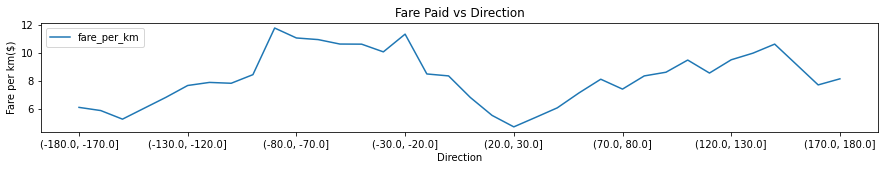

In [33]:
train.query('distance > 5').pivot_table('fare_per_km', index='direction_bucket', aggfunc='mean').plot(figsize=(15,2))
plt.ylabel('Fare per km($)')
plt.xlabel('Direction')
plt.title('Fare Paid vs Direction')
plt.show()

In [34]:
def modelling_features(df):
    df = shared_features(df)
    # using alternative representation of cyclic features
    df = df.assign(
        sin_time=np.sin(2*np.pi*df['time']/24),
        cos_time=np.cos(2*np.pi*df['time']/24),
        sin_direction=np.sin(2*np.pi*df['direction']/360),
        cos_direction=np.cos(2*np.pi*df['direction']/360),
        sin_dayofyear=np.sin(2*np.pi*df['dayofyear']/365),
        cos_dayofyear=np.cos(2*np.pi*df['dayofyear']/365),
        sin_weekday=np.sin(2*np.pi*df['weekday']/6),
        cos_weekday=np.cos(2*np.pi*df['weekday']/6),
        direction_bucket=pd.cut(df['direction'], bins=37, labels=False)
        ).drop(columns=['pickup_datetime', 'time', 'direction', 'weekday', 'dayofyear'])
    return df

In [35]:
train = load_df(10000000, features='model')

test['pickup_datetime'] = test['pickup_datetime'].str.slice(0, 15)
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
test = modelling_features(test)

train = (train
    .query(f'{test.pickup_longitude.min()-0.1} <= pickup_longitude <= {test.pickup_longitude.max()+0.1}')
    .query(f'{test.pickup_latitude.min()-0.1} <= pickup_latitude <= {test.pickup_latitude.max()+0.1}')
    .query(f'{test.dropoff_longitude.min()-0.1} <= dropoff_longitude <= {test.dropoff_longitude.max()+0.1}')
    .query(f'{test.dropoff_latitude.min()-0.1} <= dropoff_latitude <= {test.dropoff_latitude.max()+0.1}')
)

x_train, x_val, y_train, y_val = get_split_sets(train)

x_train['fare_per_km'] = y_train*1000/(x_train.distance+5)
fares_by_direction = x_train.query('5 < distance').groupby('direction_bucket')['fare_per_km'].mean()

x_train['adj_dist'] = [fares_by_direction[i] for i in x_train.direction_bucket]*x_train.distance/fares_by_direction.max()
x_val['adj_dist'] = [fares_by_direction[i] for i in x_val.direction_bucket]*x_val.distance/fares_by_direction.max()
test['adj_dist'] = [fares_by_direction[i] for i in test.direction_bucket]*test.distance/fares_by_direction.max()

x_train = x_train.drop(columns=['fare_per_km', 'direction_bucket'])
x_val = x_val.drop(columns=['direction_bucket'])
x_test = test.drop(columns=['key', 'direction_bucket'])

In [36]:
lin_final_model, lin_final_rmse, lin_final_pred = lin_model(x_train, x_val, y_train, y_val)

In [37]:
knn_cols = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']
k_choices = [18,24,30,40]
knn_final_model, knn_final_rmse, knn_final_pred = knn_model(x_train[knn_cols], x_val[knn_cols], y_train, y_val, k_choices)

Neighbours 18 RMSE 4.009113761139083
Neighbours 24 RMSE 3.9957507011693427
Neighbours 30 RMSE 3.988139590891927
Neighbours 40 RMSE 3.9861420427776557


In [38]:
lgbm_params = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'reg_sqrt': True,
    'learning_rate': 0.03,
    'num_leaves': 1200,
    'max_depth': -1,
    'max_bin': 5000,
    'num_rounds': 5000,
    'early_stopping_round': 50,
    'metric': 'rmse'
}
lgbm_final_model, lgbm_final_rmse, lgbm_final_pred = lgbm_model(lgbm_params, x_train, x_val, y_train, y_val)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.157838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100858
[LightGBM] [Info] Number of data points in the train set: 8781381, number of used features: 28
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 3.63799
[200]	valid_0's rmse: 3.48777
[300]	valid_0's rmse: 3.44798
[400]	valid_0's rmse: 3.4311
[500]	valid_0's rmse: 3.42289
[600]	valid_0's rmse: 3.41825
[700]	valid_0's rmse: 3.41464
[800]	valid_0's rmse: 3.41229
[900]	valid_0's rmse: 3.41035
[1000]	valid_0's rmse: 3.40869
[1100]	valid_0's rmse: 3.40694
[1200]	valid_0's rmse: 3.40551
[1300]	valid_0's rmse: 3.40466
[1400]	valid_0's rmse: 3.40375
[1500]	valid_0's rmse: 3.40236
[1600]	valid_0's rmse: 3.40126
[1700]	valid_0's rmse: 3.40069
[1800]	valid_0's rmse: 3.4
[1900]	valid_0's rmse: 3.39967
[2000]	valid_0's rmse: 3.39967
Early stopping, best iteration is:
[1

In [43]:
print('Linear Regression RMSE', lin_final_rmse)
print('KNN RMSE', knn_final_rmse)

Linear Regression RMSE 4.8372392448449
KNN RMSE 3.9861420427776557
